https://github.com/IlliaOvcharenko/lung-segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
os.chdir('/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master')

In [ ]:
import torch
import torchvision
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import pdb
import csv
import torchvision.transforms as T
import time
from tqdm import tqdm


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data loading

## Inference


In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:04<00:00, 107MB/s] 


In [ ]:
model_name = "unet-model1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1.pt", map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:

device

device(type='cpu')

## Test inference on random image

In [ ]:
from google.colab import output
from IPython.display import clear_output

 16%|█▌        | 77/492 [12:57<46:09,  6.67s/it]

shape =  torch.Size([1, 2, 256, 256])
mean = tensor(0.9793)
% softmax_thresh =  tensor(0.9589)
% softmax_thresh1 =  tensor(0.9358)


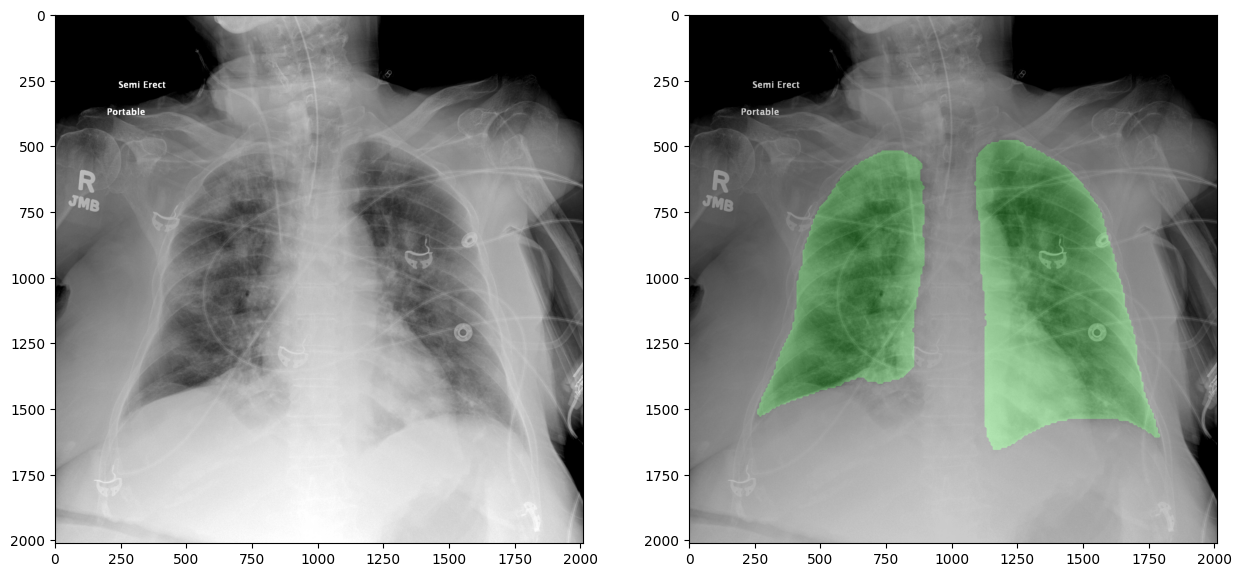

 16%|█▌        | 77/492 [14:13<1:16:39, 11.08s/it]


KeyboardInterrupt: ignored

In [ ]:
image_folder = "UPMC-ARDSy"
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/" + image_folder # read from UPMC ARDS in VeyTel database

arr = os.listdir(image_dir)
csv_file = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/self_feedback.csv'
with open(csv_file, 'a', newline='') as file:
  writer = csv.DictWriter(file, fieldnames=['image_folder', 'image_name', 'mean', '>80', '>90', 'y/n'])
  #writer.writeheader()
  for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
    if file_extension == ".png":
      image_path = os.path.join(image_dir, image_name)
      origin = Image.open(image_path).convert("L")
      origin = torchvision.transforms.functional.resize(origin, (256, 256))
      origin = torchvision.transforms.functional.to_tensor(origin)
      origin1 = Image.open(image_path).convert("RGB")
      origin1 = torchvision.transforms.functional.to_tensor(origin1)
      height = origin1.shape[1]
      width = origin1.shape[2]

      with torch.no_grad():
          origin = torch.stack([origin])
          origin = origin.to(device)
          out = unet(origin)
          softmax = torch.nn.functional.log_softmax(out, dim=1)

          print("shape = ",softmax.shape)
          softmax1 = torch.exp(softmax)
          softmax1_max = torch.max(softmax1, 1)[0]
          mean = torch.mean(softmax1_max)
          print("mean =",mean)
          softmax_thresh = torch.sum(softmax1_max>0.8)/(256*256)
          softmax_thresh1 = torch.sum(softmax1_max>0.9)/(256*256)
          print("% softmax_thresh = ",softmax_thresh)
          print("% softmax_thresh1 = ",softmax_thresh1)
          out = torch.argmax(softmax, dim=1)
          origin = origin[0].to("cpu")
          out = out[0].to("cpu")
          out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
          threshold = 0.5
          out_upsample = (out_upsample > threshold).float()
          out_reshape = torch.permute(out_upsample,(1,2,0))
          out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
          origin_reshape = torch.permute(origin1,(1,2,0))
          segmented_lung = out_reshape1 * origin_reshape

          transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
          origin_blend = transform(origin_reshape.permute(2,0,1))
          out_reshape1[:,:,0] = 0
          out_reshape1[:,:,2] = 0
          mask_blend = transform(out_reshape1.permute(2,0,1))
          origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      plt.figure(figsize=(15,9))
      plt.subplot(1, 2, 1)
      plt.imshow(origin_reshape)
      plt.subplot(1, 2, 2)
      plt.imshow(origin_blend)
      plt.show()
      time.sleep(0.1)
      feedback = input("is this good for training?\n")
      mean = round(float(mean),4)
      _80 = round(float(softmax_thresh),4)
      _90 = round(float(softmax_thresh1),4)
      data = [
              {'image_folder': image_folder, 'image_name': image_name, 'mean': mean, '>80': _80, '>90': _90, 'y/n': feedback},
              ]
      writer.writerows(data)
      clear_output()



## Code to filter CSV based on 'y/n'

In [ ]:
import pandas as pd

# Read the original CSV file
original_csv_file = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/self_feedback.csv"
df = pd.read_csv(original_csv_file)

# Create a new DataFrame to store the filtered entries
filtered_df = pd.DataFrame(columns=["image_folder", "image_name"])

# Iterate over the rows of the original DataFrame
for index, row in df.iterrows():
    image_folder = row["image_folder"]
    image_name = row["image_name"]
    use_image = row["y/n"]

    # Check if the image should be used
    if use_image == 'y':
        filtered_df = filtered_df.append({"image_folder": image_folder, "image_name": image_name}, ignore_index=True)

# Save the filtered DataFrame to a new CSV file
filtered_csv_file = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/filtered_self_feedback.csv"
filtered_df.to_csv(filtered_csv_file, index=False)